In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

asd_file = "asd.txt"
asd_columns=["freq","strain"]
gw_columns=["time", "h_plus", "h_cross", "h_H1", "h_L1"]

In [2]:
def read_file(filename,columns):
    # MAKE MORE EFFICIENTTTT
    file_dict={}
    f = open(filename,"r") 
    f_read=f.readlines()
    for line in f_read[1:]:
        split_line=line.split()
        for i in range(len(columns)):
            try:
                file_dict[columns[i]].append(float(split_line[i]))
            except:
                file_dict[columns[i]]=[float(split_line[i])]
                
    for i in range(len(columns)):
        file_dict[columns[i]]=np.array(file_dict[columns[i]])
    return file_dict

In [3]:
# reads in the asd and waveform files

asd_data=read_file(asd_file,asd_columns)
GW150914_median_data=read_file("waveforms/GW150914_median.txt",gw_columns)
#GW151226_aligned_data=read_file("waveforms/GW151226_aligned.txt",gw_columns)
#LVT151012_aligned_data=read_file("waveforms/LVT151012_aligned.txt",gw_columns)

# asd file isn't the same length as the waveform templates; interpolate
asd_func = interpolate.interp1d(asd_data["freq"], asd_data["strain"])

wave_event_data=GW150914_median_data
#wave_event_data=GW151226_aligned_data
#wave_event_data=LVT151012_aligned_data

In [4]:
# modified slightly from the ligo code

#complex is easier to deal with
waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
dt = wave_event_data["time"][1]-wave_event_data["time"][0]
fs = 4096 

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.absolute(np.unwrap(np.angle(waveform)))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
iffix = np.where(np.absolute(waveform) < np.absolute(waveform).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# get the fft of the waveform:
waveform_fft = np.fft.fft(wave_event_data["h_L1"]) * dt
waveform_freq = np.fft.fftfreq(wave_event_data["h_L1"].size) * fs
freqs = waveform_freq
waveform_f = np.absolute(waveform_fft)*np.sqrt(np.abs(freqs))

# asd data starts at a higher freq
freqs_cut = freqs[np.where(freqs>=9.)]
waveform_fft_cut = waveform_fft[np.where(freqs>=9.)]
waveform_f_cut = waveform_f[np.where(freqs>=9.)]

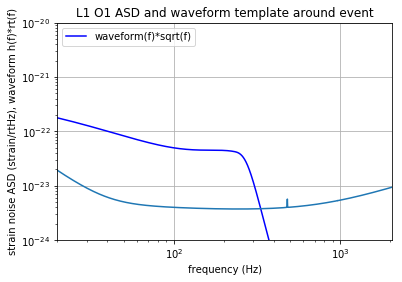

In [7]:
#plotting to see if everything is ok
plt.figure()
plt.loglog(freqs_cut, waveform_f_cut, 'b', label='waveform(f)*sqrt(f)')
plt.loglog(freqs_cut,asd_func(freqs_cut))
plt.xlim(20, fs/2)
plt.ylim(1e-24, 1e-20)
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain noise ASD (strain/rtHz), waveform h(f)*rt(f)')
plt.legend(loc='upper left')
plt.title('L1 O1 ASD and waveform template around event')
plt.show()

In [8]:
# calculating SNR; modified from FINDCHIRP
SNR_integrand = 4*((np.absolute(waveform_fft_cut))**2/((asd_func(freqs_cut))**2))
SNR_mean= np.sqrt(np.trapz(SNR_integrand, freqs_cut))
print SNR_mean
SNR_stoc = SNR_mean+np.random.normal()
print SNR_stoc

43.5942280457
43.0627068607
